The aim of this notebook is to demonstrate how to implement logistic regression with stochastic gradient descent. 

In this project, we are trying to do gender voice recognition with logistic regression. The data is obtained from kaggle, where each voice signal has already been analyzed and the data about the voice samples are recorded numerically. 

# Prepare notebook and import data

In [56]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import *
from math import *

In [20]:
# import the data and see what is in there (first ten lines)

df_voice=pd.read_csv("voice.csv")
df_voice.shape

(3168, 21)

Taking a look at the dataframe itself:

In [21]:
df_voice.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


All the variables are represented below:

In [22]:
list(df_voice.columns)

['meanfreq',
 'sd',
 'median',
 'Q25',
 'Q75',
 'IQR',
 'skew',
 'kurt',
 'sp.ent',
 'sfm',
 'mode',
 'centroid',
 'meanfun',
 'minfun',
 'maxfun',
 'meandom',
 'mindom',
 'maxdom',
 'dfrange',
 'modindx',
 'label']

Since label is now a categorical data, split into males and females, it would be beneficial to convert them to 0 and 1, where 0 represent females and 1 represent males

In [23]:
gender_dict = {"male":1.0, "female":0.0}
df_voice["gender"] = df_voice["label"].map(gender_dict);
df_voice = df_voice.drop("label",1)

In [24]:
df_voice.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,gender
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,1.0
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,1.0
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,1.0
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,1.0
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,1.0


This is the data that we have, and from the data, we observe several problems:

1. The data is listed in such a way that the male voices comes first and female voices comes later, therefore we need to shuffle the rows to ensure that both male and female voices are taken into account of the learning process.
2. Males and females are label, and we need to change them into 0 and 1 so that we can fit the data into the logistic regression algorithm
3. We need a set of testing data to test the algorithm. 

In [25]:
df_voice = (df_voice - df_voice.mean()) / (df_voice.max() - df_voice.min())

In [26]:
gender_num_dict = {0.5:1.0, -0.5:0.0}
df_voice["gender"] = df_voice["gender"].map(gender_num_dict);

In [27]:
df_voice = df_voice.iloc[np.random.permutation(len(df_voice))]

In [28]:
df_voice.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,gender
35,-0.100945,0.187258,-0.154915,-0.077117,0.063359,0.141638,-0.033156,-0.022713,0.106866,0.216255,...,-0.100945,-0.123865,-0.094643,-0.513695,-0.154699,-0.098732,-0.111527,-0.109554,0.046189,1.0
627,-0.077168,0.098706,-0.062242,-0.088110,-0.018893,0.073288,-0.054276,-0.024488,0.271365,0.362597,...,-0.077168,-0.129024,-0.015679,0.019616,-0.215011,-0.098732,-0.199089,-0.197179,0.034188,1.0
1375,0.075031,0.006741,0.104885,0.020391,0.102318,0.078041,-0.056251,-0.024901,0.044442,-0.103720,...,0.075031,-0.071623,0.055186,0.114915,-0.059927,-0.064324,-0.019675,-0.018352,-0.076912,1.0
2425,0.181834,-0.201178,0.151694,0.272120,0.052881,-0.231650,-0.014459,-0.019957,-0.217464,-0.210421,...,0.181834,0.045072,0.053981,0.105751,0.581402,-0.064324,0.292333,0.293880,-0.032648,0.0
446,-0.010806,0.162614,0.079876,-0.059089,0.066089,0.125541,-0.042234,-0.023494,0.186387,0.240967,...,-0.010806,-0.173962,-0.106809,-0.561536,0.052686,-0.047120,0.074678,0.075711,0.044632,1.0


It is also beneficial to split the data into training and testing data, so that we can verify whether logistic regression can accurately predict the gender of a voice. 

In [29]:
df_test = pd.DataFrame()
df_train = pd.DataFrame()
df_train = df_voice[:2100]
df_test = df_voice[2100:]

In [30]:
df_train.shape

(2100, 21)

In [31]:
# Now we split the testing data to a column vector of gender and
y_train = df_train["gender"].as_matrix()
X_train = df_train.drop("gender",1).as_matrix()
y_test = df_test["gender"].as_matrix()
X_test = df_test.drop("gender",1).as_matrix()

In [32]:
y_train = y_train.transpose()
X_train = X_train.transpose()
X_train = np.append(np.ones((1,2100)), X_train, axis = 0)
y_test = y_test.transpose()
X_test = X_test.transpose()
X_test= np.append(np.ones((1,1068)), X_test, axis = 0)

In [33]:
def sigmoid(x):
    result = 1.0/(1.0+np.exp(-x))
    return result

In [34]:
def log_likelihood(x,y,w):
    item = np.dot(np.transpose(w),x)
    result = y*log(sigmoid(item))+(1-y)*log(1.0-(sigmoid(item)))
    return result

In [64]:
weight_plotter = []
def stochGradDescent(outputVector,inputMatrix,learningSpeed):
    #outputVector should be a binary column vector of classifications
    # every column is a single trial, every row is a feature
    a = learningSpeed
    y = outputVector
    X = inputMatrix
    numberOfTrials = y.shape[0]
    numberOfEstimators = X.shape[0]
    prev_weight = np.ones(numberOfEstimators) #estimator vector (_t_heta)
    weight = np.zeros(numberOfEstimators)
    error = 10000.0
    prev_training_cost = 1000.0
    training_cost = 0 # This is what we're trying to maximize, the log likelihood
    # add an additional loop to observe the training_cost
    while ((prev_training_cost < training_cost) or (abs(prev_training_cost - training_cost) > 1e-10)):
        training_cost = 0.0
        while (np.linalg.norm(prev_weight-weight,ord=2) > 1e-6):
            prev_weight = weight
            # Randomly choose an integer
            i = randint(1,2099)
            grad = (y[i] - sigmoid(np.dot(np.transpose(prev_weight),X[:,i])))
            weight = prev_weight + a * grad * X[:,i]
            training_cost += log_likelihood(X[:,i],y[i],weight) 
            weight_plotter.append(np.linalg.norm(weight,ord=2))
        prev_training_cost = training_cost
    return weight

In [65]:
theta = stochGradDescent(y_train,X_train,1.0/200.0)
theta

array([ -3.36397254e-01,   4.54430213e-01,   9.71622213e-01,
        -4.31239524e-01,  -2.48662876e+00,   2.66592841e+00,
         5.17129792e+00,  -1.39260180e+00,  -8.01885800e-01,
         2.68968525e+00,  -2.45014710e+00,   1.26528210e+00,
         4.54430213e-01,  -1.49776343e+01,   1.00181512e+00,
        -8.48963305e-01,   1.50805198e-02,  -4.40295733e-01,
        -1.14774326e-02,  -2.33249895e-03,  -8.92495772e-01])

In [39]:
def predict(inputVector,estimatorVector):
    t = estimatorVector
    x = inputVector
    confidence = sigmoid(np.dot(np.transpose(t) , x))
    if confidence > 0.5:
        return 1
    else:
        return 0

In [66]:
correct = 0
wrong = 0
total = 0
for j in range(1068):
    # print(predict(X_test[:,j],theta)), y_test[j]
    if (y_test[j] == predict(X_test[:,j],theta)):
        correct += 1
    else:
        wrong += 1
    total += 1
print correct, wrong, total

1030 38 1068


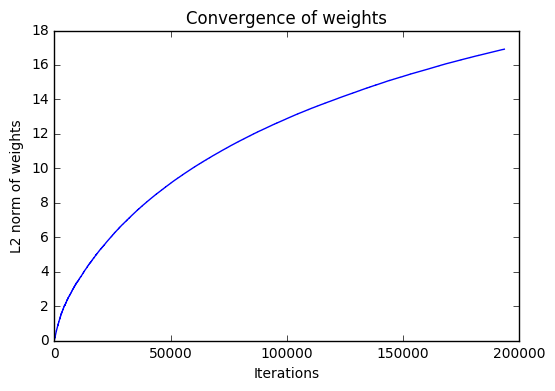

In [67]:
x = []
for i in range(len(weight_plotter)):
    x.append(i)
plt.plot(x,weight_plotter)
plt.title("Convergence of weights")
plt.xlabel("Iterations")
plt.ylabel("L2 norm of weights")
plt.show()